In [21]:
import time
import matplotlib.pyplot as plt
import numpy as np

In [22]:
x0 = 0
x_end = 1.5
y0 = 0.5   # y(0) = 1/2
yp0 = 10    # y'(0) = 10
h = 0.0001   # Шаг

In [23]:
def derivatives(u, y):
    "Правая часть ОДУ: y' = u, u' = -10u - y + y^3"
    dy = u
    du = -10 * u - y + y**3 
    return dy, du

In [24]:
def stormer_acceleration(y, dy):
    "Вторая производная для метода Штермера: y'' = -10dy - y + y^3"
    return -10 * dy - y + y**3 

Метод Рунге-Кутты

In [25]:
def runge_kutta(x0, x_end, y0, yp0, h):
    x = [x0]
    y = [y0]
    u = [yp0]
    max_steps = int((x_end - x0) / h) + 1  # Ограничение шагов
    
    for step in range(max_steps):
        if x[-1] >= x_end:
            break
        
        # Проверка наличия элементов в списках
        if len(y) == 0 or len(u) == 0:
            raise ValueError("Списки y или u пусты!")
        
        # Вычисление коэффициентов
        try:
            current_u = u[-1]
            current_y = y[-1]
            k1_y, k1_u = derivatives(current_u, current_y)
            k2_y, k2_u = derivatives(current_u + 0.5*h*k1_u, current_y + 0.5*h*k1_y)
            k3_y, k3_u = derivatives(current_u + 0.5*h*k2_u, current_y + 0.5*h*k2_y)
            k4_y, k4_u = derivatives(current_u + h*k3_u, current_y + h*k3_y)
        except OverflowError:
            print(f"Переполнение на шаге {step}. Последние значения: y={current_y}, u={current_u}")
            break
        
        # Обновление значений
        new_y = current_y + (k1_y + 2*k2_y + 2*k3_y + k4_y) * h / 6
        new_u = current_u + (k1_u + 2*k2_u + 2*k3_u + k4_u) * h / 6
        new_x = x[-1] + h
        
        # Проверка на NaN или бесконечность
        if not (abs(new_y) < 1e100 and abs(new_u) < 1e100):
            print(f"Аномальные значения на шаге {step}. Последние значения: y={current_y}, u={current_u} Остановка.")
            break
        
        x.append(new_x)
        y.append(new_y)
        u.append(new_u)
    
    return x, y

In [26]:
start = time.time()
x_rk, y_rk = runge_kutta(x0, x_end, y0, yp0, h)
time_rk = time.time() - start

In [27]:
print(f"Время Рунге-Кутта: {time_rk:.3f} сек")

Время Рунге-Кутта: 0.033 сек


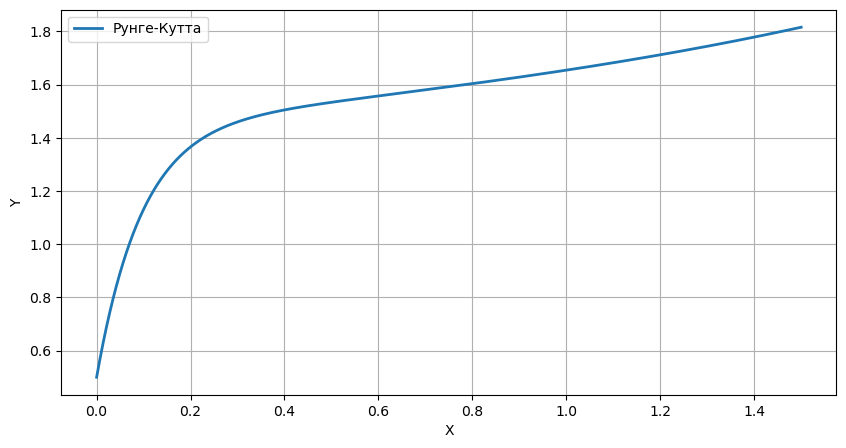

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(x_rk, y_rk, lw=2, label='Рунге-Кутта')
plt.xlabel('X')
plt.ylabel('Y') 
plt.grid(True)
plt.legend()
plt.show()


Метод Штермера

In [41]:
def stormer(x0, x_end, y0, yp0, h):
    x = [x0]
    y = [y0]
    
    # Первый шаг методом Эйлера
    if len(x) < 2:
        dy = yp0
        y_next = y[0] + dy*h + 0.5*h**2*stormer_acceleration(y[0], dy)
        x.append(x[0] + h)
        y.append(y_next)
    
    # Основной цикл
    while x[-1] < x_end:
        acceleration = stormer_acceleration(y[-1], (y[-1]-y[-2])/h)
        try:
            # Вычисляем следующие значения
            y_next = 2 * y[-1] - y[-2] + h**2 * acceleration
            x_next = x[-1] + h

    # Проверяем на аномальные значения
            if abs(x_next) > 1e100 or abs(y_next) > 1e100:
                raise OverflowError("Аномальный рост решения")

        except OverflowError as e:
            # Ловим конкретное исключение
            print(f"\033[31mОшибка: {e}. Последние значения: y={y[-1]}, x={x[-1]}. Остановка.\033[0m")
            break
        except Exception as e:
            # Ловим другие ошибки (например, деление на ноль)
            print(f"\033[31mНепредвиденная ошибка: {e}\033[0m")
            break
        else:
            # Если ошибок нет, добавляем значения в массивы
            y.append(y_next)
            x.append(x_next)
    return x, y

In [42]:
start = time.time()
x_st, y_st = stormer(x0, x_end, y0, yp0, h)
time_st = time.time() - start

In [31]:
print(f"Время Штермера:    {time_st:.3f} сек")

Время Штермера:    0.018 сек


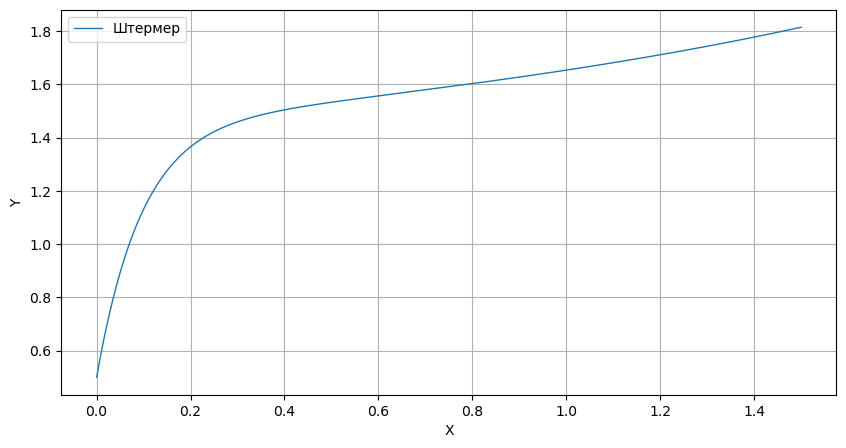

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(x_st, y_st, lw=1, label='Штермер')
plt.xlabel('X')
plt.ylabel('Y') 
plt.grid(True)
plt.legend()
plt.show()


Метод Адамса

In [33]:
def adams(x0, x_end, y0, yp0, h):
    x = [x0]
    y = [y0]
    u = [yp0]  # Первая производная
    
    # Первые 4 точки методом Рунге-Кутты
    for _ in range(3):
        current_u = u[-1]
        current_y = y[-1]
        k1_y, k1_u = derivatives(current_u, current_y)
        k2_y, k2_u = derivatives(current_u + 0.5*h*k1_u, current_y + 0.5*h*k1_y)
        k3_y, k3_u = derivatives(current_u + 0.5*h*k2_u, current_y + 0.5*h*k2_y)
        k4_y, k4_u = derivatives(current_u + h*k3_u, current_y + h*k3_y)
        
        new_y = current_y + (k1_y + 2*k2_y + 2*k3_y + k4_y) * h / 6
        new_u = current_u + (k1_u + 2*k2_u + 2*k3_u + k4_u) * h / 6
        new_x = x[-1] + h
        
        x.append(new_x)
        y.append(new_y)
        u.append(new_u)
        
    # Основной цикл
    while x[-1] < x_end:
        # Вычисление производных для метода Адамса
        du_current = derivatives(u[-1], y[-1])[1]  # Вторая производная (du)
        du_prev1 = derivatives(u[-2], y[-2])[1]
        du_prev2 = derivatives(u[-3], y[-3])[1]
        du_prev3 = derivatives(u[-4], y[-4])[1]
        
        # Формула Адамса для u
        new_u = u[-1] + h/24 * (55 * du_current 
                               - 59 * du_prev1 
                               + 37 * du_prev2 
                               - 9 * du_prev3)
        
        # Формула Адамса для y
        new_y = y[-1] + h/24 * (55 * u[-1] 
                               - 59 * u[-2] 
                               + 37 * u[-3] 
                               - 9 * u[-4])
        
        new_x = x[-1] + h
        
        x.append(new_x)
        y.append(new_y)
        u.append(new_u)
    
    return x, y

In [34]:
start = time.time()
x_ad, y_ad = adams(x0, x_end, y0, yp0, h)
time_ad = time.time() - start   

In [35]:
print(f"Время Адамса:      {time_ad:.3f} сек")

Время Адамса:      0.039 сек


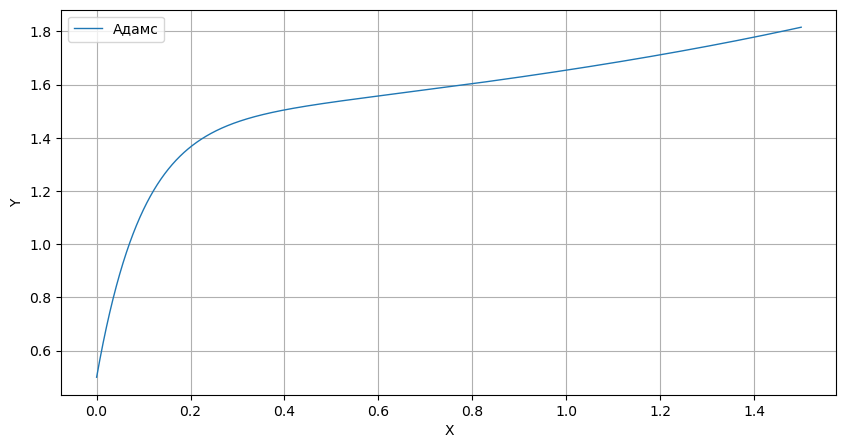

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(x_ad, y_ad, lw=1, label='Адамс')
plt.xlabel('X')
plt.ylabel('Y') 
plt.grid(True)
plt.legend()
plt.show()

Все графики

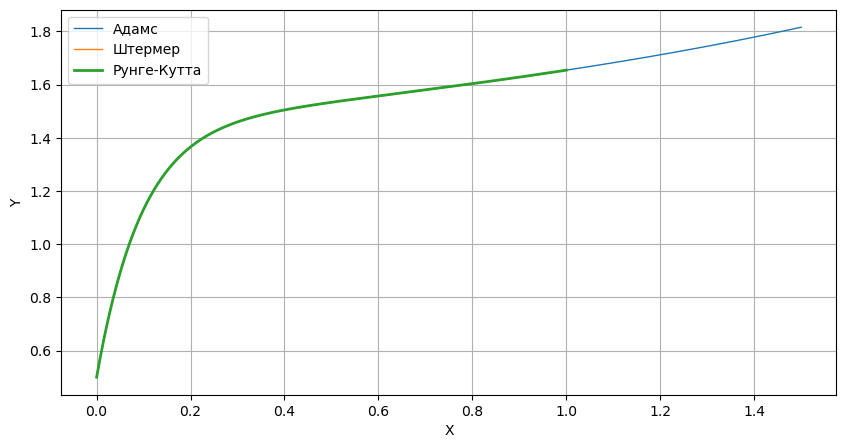

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(x_ad, y_ad, lw=1, label='Адамс')
plt.plot(x_st, y_st, lw=1, label='Штермер')
plt.plot(x_rk, y_rk, lw=2, label='Рунге-Кутта')
plt.xlabel('X')
plt.ylabel('Y') 
plt.grid(True)
plt.legend()
plt.show()

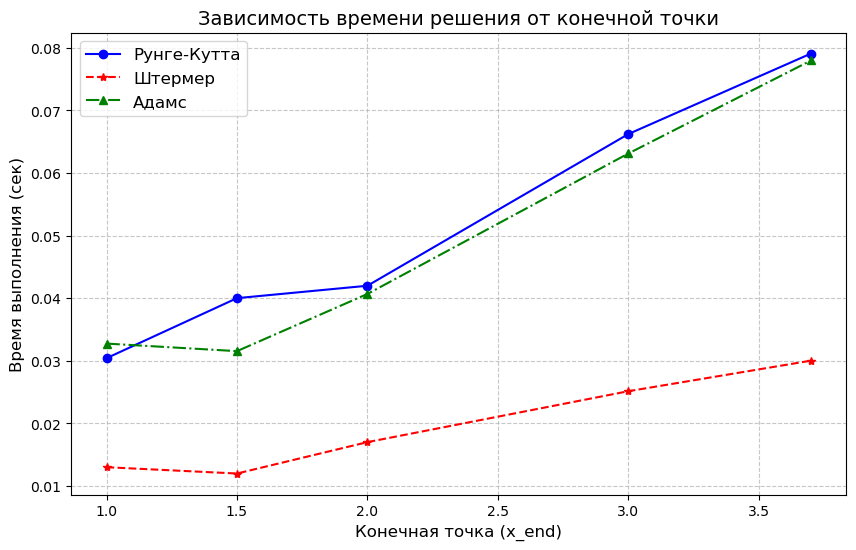

In [48]:
x_end_list = [1, 1.5, 2, 3, 3.7]
times_rk = []
times_st = []
times_ad = []
for x_end in x_end_list:
        # Рунге-Кутта
    start = time.time()
    x_rk, y_rk = runge_kutta(x0, x_end, y0, yp0, h)
    times_rk.append(time.time() - start)
        
        # Штермер
    start = time.time()
    x_st, y_st = stormer(x0, x_end, y0, yp0, h)
    times_st.append(time.time() - start)
        
        # Адамс
    start = time.time()
    x_ad, y_ad = adams(x0, x_end, y0, yp0, h)
    times_ad.append(time.time() - start)
plt.figure(figsize=(10, 6))
plt.plot(x_end_list, times_rk, 'bo-', label='Рунге-Кутта')
plt.plot(x_end_list, times_st, 'r*--', label='Штермер')
plt.plot(x_end_list, times_ad, 'g^-.', label='Адамс')
    
plt.xlabel('Конечная точка (x_end)', fontsize=12)
plt.ylabel('Время выполнения (сек)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.title("Зависимость времени решения от конечной точки", fontsize=14)
plt.show()
    